In [ ]:
from google.colab import auth
auth.authenticate_user()
!gcloud config set project sfhs-333010
import warnings
warnings.filterwarnings('ignore')

Updated property [core/project].


In [ ]:
!echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
!apt -qq update
!apt -qq install gcsfuse

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2537  100  2537    0     0  59000      0 --:--:-- --:--:-- --:--:-- 60404
OK
55 packages can be upgraded. Run 'apt list --upgradable' to see them.
The following NEW packages will be installed:
  gcsfuse
0 upgraded, 1 newly installed, 0 to remove and 55 not upgraded.
Need to get 12.5 MB of archives.
After this operation, 28.5 MB of additional disk space will be used.
Selecting previously unselected package gcsfuse.
(Reading database ... 155222 files and directories currently installed.)
Preparing to unpack .../gcsfuse_0.38.0_amd64.deb ...
Unpacking gcsfuse (0.38.0) ...
Setting up gcsfuse (0.38.0) ...


In [ ]:
!mkdir data
!gcsfuse --implicit-dirs tng100 data


2021/12/07 11:07:46.241355 Start gcsfuse/0.38.0 (Go version go1.17.3) for app "" using mount point: /content/data
2021/12/07 11:07:46.255003 Opening GCS connection...
2021/12/07 11:07:46.491283 Mounting file system "tng100"...
2021/12/07 11:07:46.522844 File system has been successfully mounted.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib 
import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)

# TNG100 SEDs (No dust)
The objective is to predict the SFHs (middle column) or time at which half of the stellar mass has been built (right column) using the galaxy Spetral Energy Distribution (SED, left column)

The SEDs shown here do not contain dust emission. Therefore they lack of realism, especially at longer wavelengths. However, the sample is large.

In [ ]:
def find_summaries(mass, time, percentiles=np.linspace(0.1, 0.9, 9)):

    ''' compute the half mass and the half time of a galaxy 
          Input: the sfh
          Output: the half mass, the corresponding half time, and the index of the mass/time summary
    '''

    summary_masses = []
    summary_times = []
    summary_indices = []
    for percentile in percentiles:
        summary_mass = min(mass, key=lambda x: abs(x-mass[0]*percentile))  # find mass closest to the half mass
        summary_masses.append(summary_mass)
        summary_mass_indices = np.where(mass == summary_mass)[0]  # find the corresponding indices
        summary_mass_index = summary_mass_indices[0]  # chose the first index for the half mass
        summary_indices.append(summary_mass_index)
        summary_time = time[summary_mass_index]  # find the corresponding half time
        summary_times.append(summary_time)

    return summary_times, summary_masses, summary_indices

In [ ]:
def plot_with_summaries(fig, axs, index, flux, wl, sfh):
  axs[index, 0].scatter(np.array(wl)[np.array(wl)<10**3],np.log10(flux),s=10)
  axs[index, 0].set_xlabel("wavelength [$\mu m$]")
  axs[index, 0].set_xscale('log')
  axs[index, 0].set_ylabel("$\log(f)$ [Jy]")
  axs[index, 1].set_xlabel("Time")
  axs[index, 1].set_ylabel("SFR")
  axs[index, 1].plot(sfh.time,sfh.SFR_halfRad)
  axs[index, 2].plot(sfh.time, np.log10(sfh.Mstar_Half)+10)
  # axs[index, 2].set_title(f'{half_mass:.2f}, {half_time:.2f}', fontsize=6)
  
  # axs[index, 2].set_title(half_mass, half_time)
  # print(np.nanmin(np.log10(sfh.Mstar_Half)+10), np.max(np.log10(sfh.Mstar_Half)+10))
  half_times, half_masses, half_indices = find_summaries(sfh.Mstar_Half, sfh.time)

  # ninth_mass, ninth_time, ninth_mass_index = find_summaries(sfh, 0.9)
  for i in range(len(half_masses)):
      axs[index, 2].vlines(sfh.time[half_indices[i]], 6.5, np.max(np.log10(sfh.Mstar_Half)+10)+0.5)
      axs[index, 2].text(sfh.time[half_indices[i]], 6.3, (i+1)/10, rotation='vertical')
      # axs[index, 2].vlines(sfh.time[ninth_mass_index], 6.5, np.max(np.log10(sfh.Mstar_Half)+10)+0.5, color='red', label='0.9')
  axs[index, 2].set_xlabel("Time")
  axs[index, 2].set_ylabel("Mstar")
  # axs[index, 2].legend(fontsize=5)

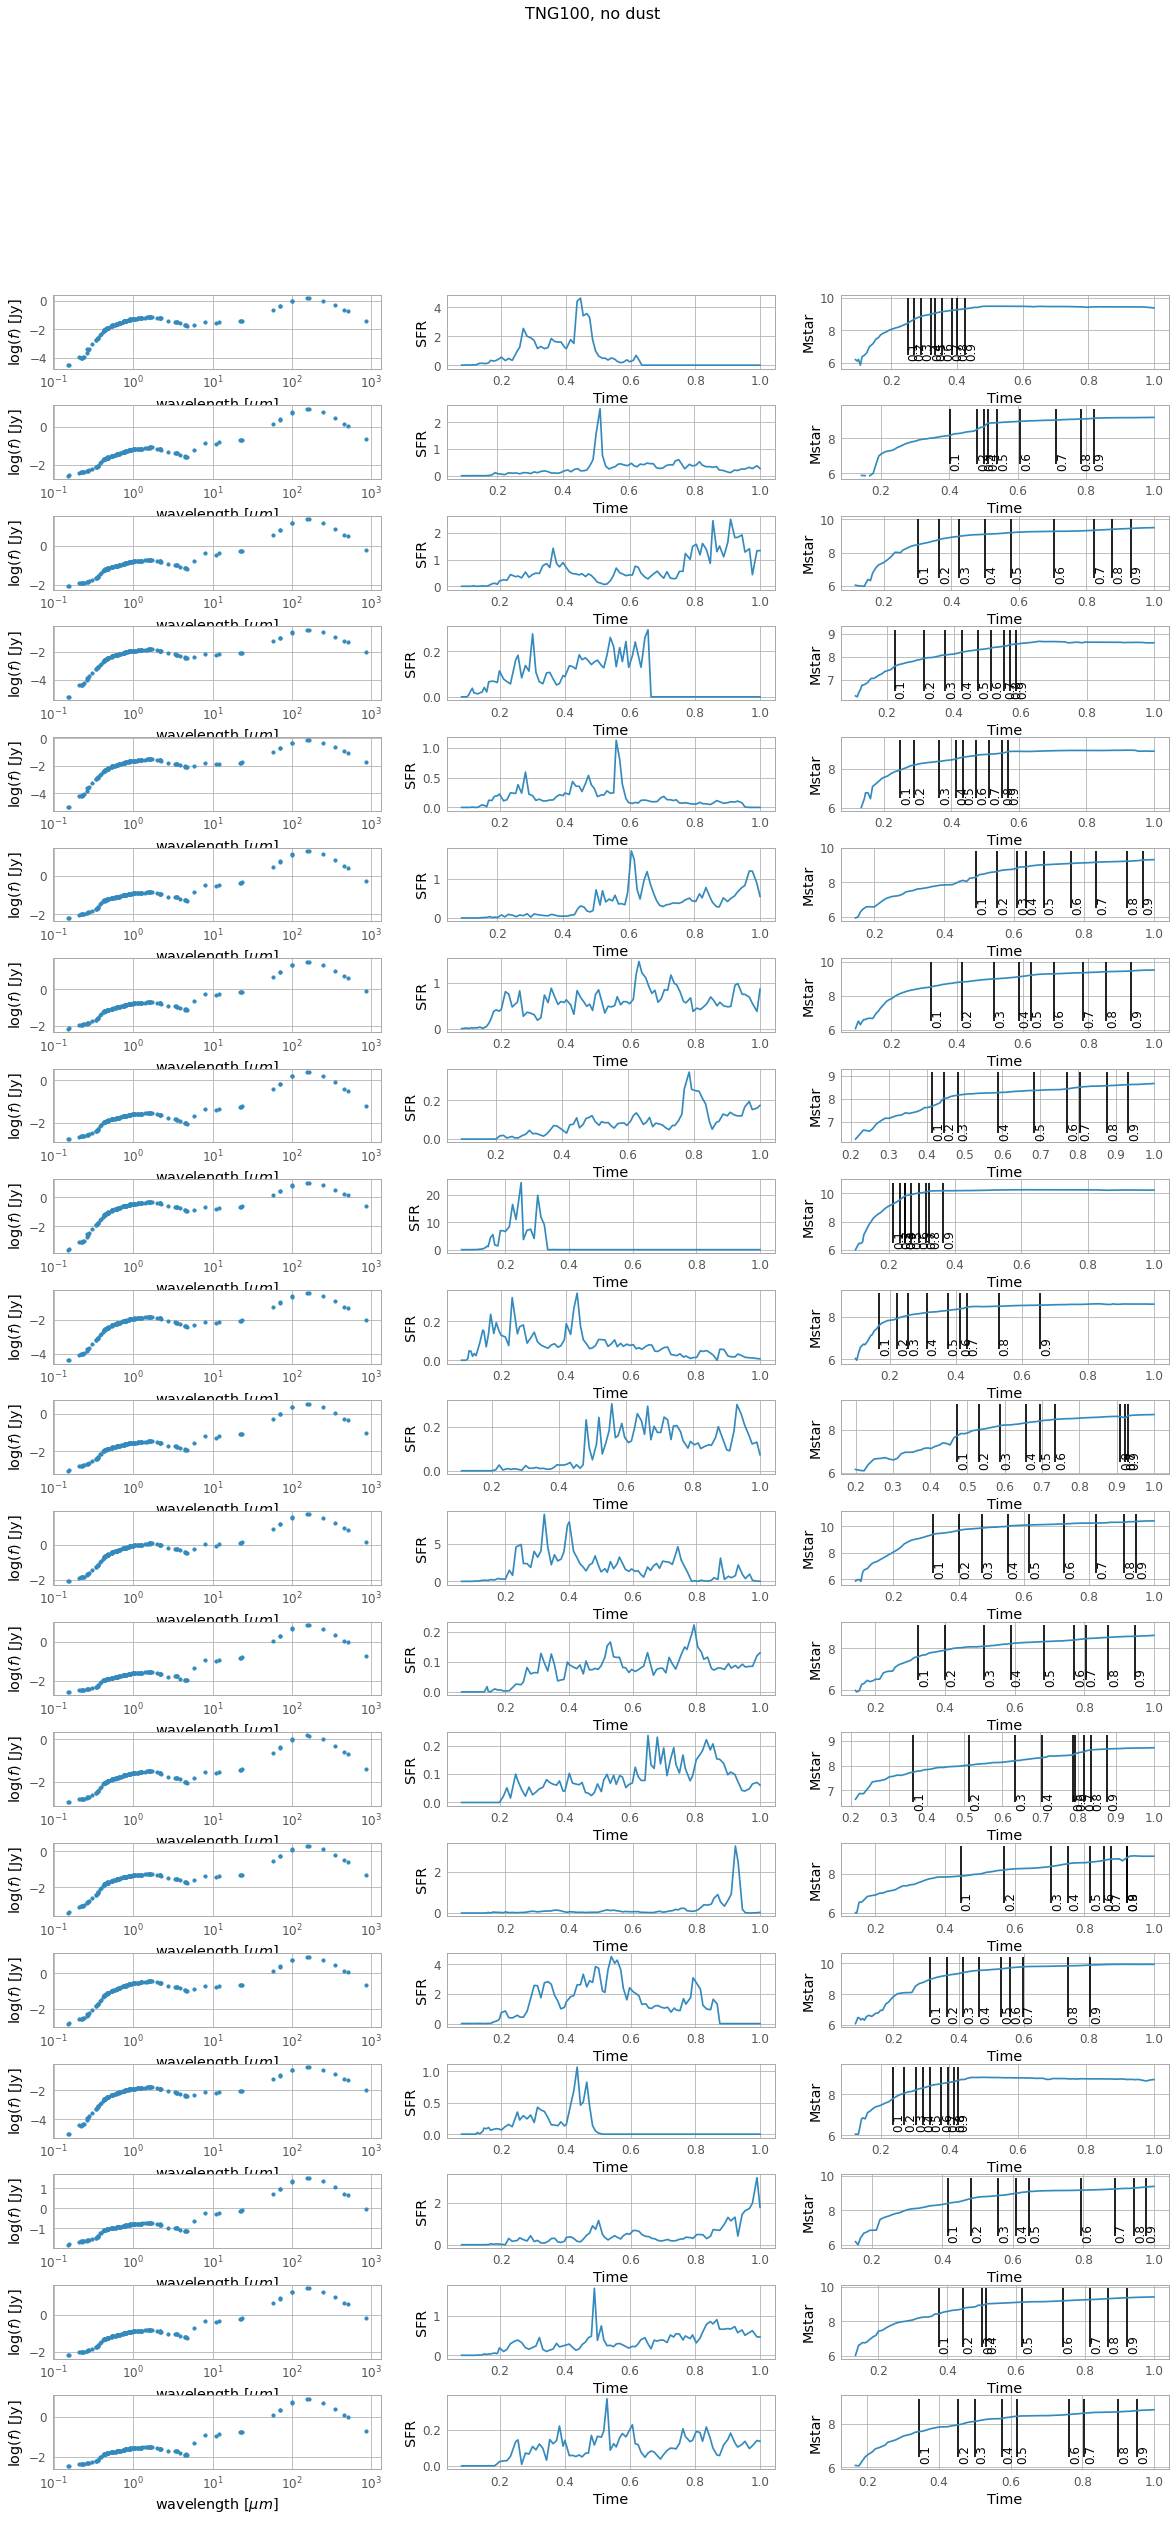

In [ ]:

from numpy import random
from numpy import loadtxt

# load catalogs
cat_path = "/content/data/phot_TNG100_dylan_143.csv"
phot_cat = pd.read_csv(cat_path)
sfh_path = "/content/data/cats_SFH/"
wl = loadtxt('/content/data/wl.csv', delimiter=',')/10**4

#index pandas table
shids = phot_cat['subhaloIDs']
phot_cat.set_index("subhaloIDs", inplace=True)
phot_cat.head()

#plot figures
fig, axs = plt.subplots(20, 3)
fig.set_size_inches(20, 40)
fig.suptitle("TNG100, no dust", fontsize=16)
for index in range(20):
    sh = int(shids[index+random.randint(0,high=len(shids)-20)])
    obj=phot_cat.loc[sh][:]
    #apparent mags
    app_mag = obj.values+5*(np.log10(20e6)-1) #assume at 20pc
    flux = 10**(.4*(-app_mag[np.array(wl)<10**3]+8.90)) #convert to Jy
    
    try:
      sfh = pd.read_csv(sfh_path+"TNG100_mainprojenitors_"+str(sh)+".csv")
    except:
      continue
    plot_with_summaries(fig, axs, index, flux, wl, sfh)
# plt.savefig("/content/data/TNG100_examples.pdf")

#Images
In addition to photometric information, we also have mock images for all the galaxies in the sample. The following cell shows an example of an image without and with noise added (SDSS)

Text(0, 0.5, 'Mstar')

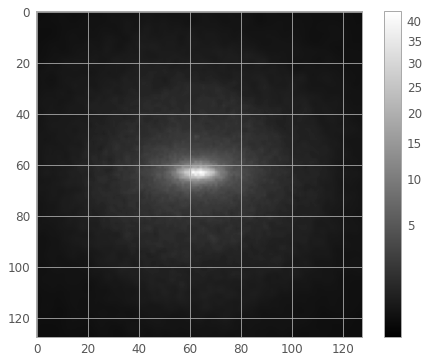

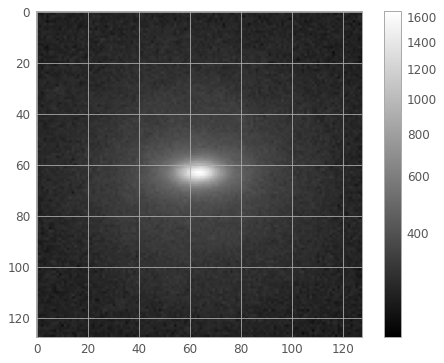

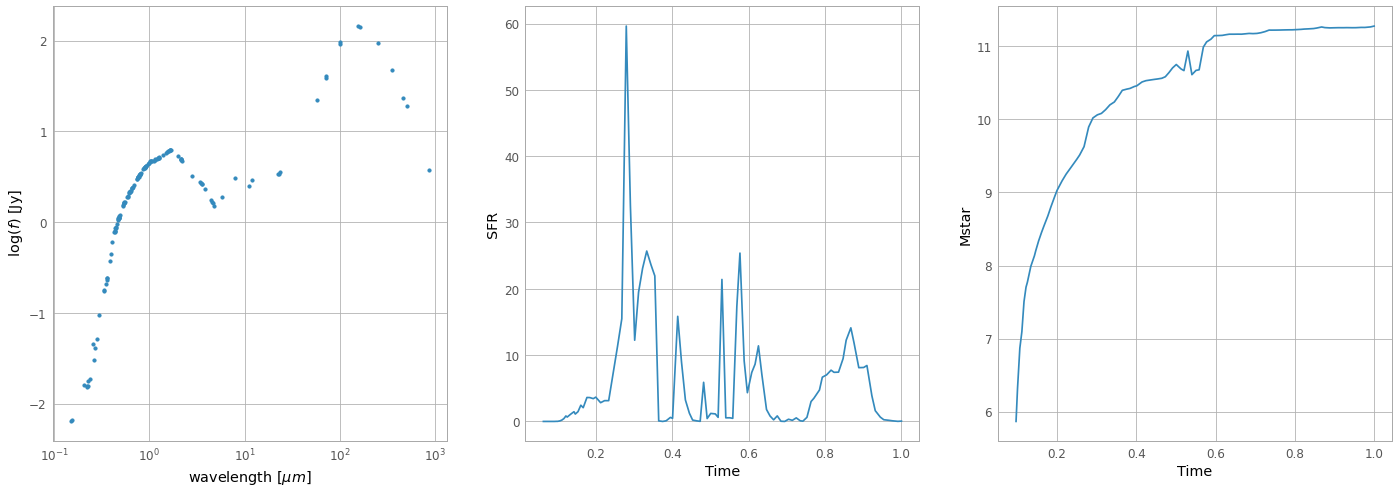

In [ ]:
from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits
from astropy.visualization import simple_norm

shid=1

#noiseless image
image_path = "/content/data/images/TNG100/sdss/sn99/noiseless"
image_file = image_path+'/broadband_'+str(int(shid))+'.fits'
image_data = fits.getdata(image_file, ext=0)
plt.figure()
fig.suptitle("Noiseless image", fontsize=16)
norm = simple_norm(image_data[3,:,:], 'sqrt')
shape = image_data[3,:,:].shape

plt.imshow(image_data[3,int(shape[0]/2)-64:int(shape[0]/2)+64,int(shape[1]/2)-64:int(shape[1]/2)+64], cmap='gray',norm=norm)
plt.colorbar()


#image with noise + SDSS PSF
image_path = "/content/data/images/TNG100/sdss/sn99/Outputs/i"
image_file = image_path+'/broadband_'+str(int(shid))+'_FullReal.fits_i_band_FullReal.fits'
image_data = fits.getdata(image_file, ext=0)
plt.figure()
fig.suptitle("SDSS image", fontsize=16)
norm = simple_norm(image_data, 'sqrt')
plt.imshow(image_data, cmap='gray', norm=norm)
plt.colorbar()



fig, axs = plt.subplots(1, 3)
fig.set_size_inches(24, 8)
obj=phot_cat.loc[shid][:]
app_mag = obj.values+5*(np.log10(20e6)-1) #assume at 20pc
flux = 10**(.4*(-app_mag[np.array(wl)<10**3]+8.90)) #convert to Jy
axs[0].scatter(np.array(wl)[np.array(wl)<10**3],np.log10(flux),s=10)

axs[0].set_xlabel("wavelength [$\mu m$]")
axs[0].set_ylabel(' $\log(f)$ [Jy]')
axs[0].set_xscale('log')

try:
  sfh = pd.read_csv(sfh_path+"TNG100_mainprojenitors_"+str(shid)+".csv")
except:
  print("not found")
axs[1].set_xlabel("Time")
axs[1].set_ylabel("SFR")
axs[1].plot(sfh.time,sfh.SFR_halfRad)
axs[2].plot(sfh.time,np.log10(sfh.Mstar_Half)+10)
axs[2].set_xlabel("Time")
axs[2].set_ylabel("Mstar")



# TNG50, with dust
There are 3000 galaxies modeled with SKIRT with dust.

In [1]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf
%load_ext autoreload

%autoreload 2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

In [ ]:
class SubHalos:
    def __init__(self, filename):
        self.filename = filename
        self._raw = np.load(filename)
        self._data = self._raw['data']
        self._wavelengths = self._raw['wl']
        self._times = self._raw['times']

    def __getitem__(self, i):
        return SubHalo(self._data[i], wl=self._wavelengths, times=self._times)
    def __len__(self):
      return len(self._data)
    @property
    def shf_times(self):
        return self._times

    @property
    def wl(self):
        return self._wavelengths


class SubHalo:
    def __init__(self, row, wl=None, times=None):
        self._shid = row[0]
        self._fluxes = row[1:144]
        self._mstar = row[244:344]
        self._sfr = row[144:244]
        self._quantiles = row[344:]
        self._wl = wl
        self._times = times

    @property
    def shid(self):
        return self._shid

    @property
    def fluxes(self):
        return self._fluxes

    @property
    def mstar(self):
        return self._mstar

    @property
    def sfr(self):
        return self._sfr

    @property
    def wl(self):
        return self._wl

    @property
    def times(self):
        return self._times
      
    @property
    def quantiles(self):
        return self._quantiles

In [ ]:

np.linspace(0.1, 0.9, 9)

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [ ]:
def find_summaries(mass, time, percentiles=np.linspace(0.1, 0.9, 9)):

    ''' compute the half mass and the half time of a galaxy 
          Input: 
                - mass: array. The mass history of the galaxy.
                - time: array. The corresponding time for the galaxy history.
                - percentiles: array. The summaries you want to predict by default 0.1, 0.2,..., 0.9. 
          Output: the time of the summaries, the corresponding masses, and the index of the mass/time summary.
    '''

    summary_masses = []
    summary_times = []
    summary_indices = []
    for percentile in percentiles:
        summary_mass = min(mass, key=lambda x: abs(x-mass[0]*percentile))  # find mass closest to the half mass
        # print(summary_mass)
        summary_masses.append(summary_mass)
        summary_mass_indices = np.where(mass == summary_mass)[0]  # find the corresponding indices
        summary_mass_index = summary_mass_indices[0]  # chose the first index for the half mass
        summary_indices.append(summary_mass_index)
        summary_time = time[summary_mass_index]  # find the corresponding half time
        summary_times.append(summary_time)

    return summary_times, summary_masses, summary_indices

In [ ]:
%ls 

drive/  my_dataset/  my_dataset2/  sample_data/


In [ ]:
filename = '/content/drive/MyDrive/hackathon/sfh_data.npz'
table = SubHalos(filename)

In [ ]:

for gal in range(len(table)):
  subhalo = table[gal]
  mass = subhalo.mstar
  flux = subhalo.fluxes
  time = subhalo.times
  subhalo.quantiles[:], _, _ = find_summaries(mass, time)


In [ ]:
np.savez('/content/drive/MyDrive/hackathon/sfh_data_good.npz', data=table._data, times=table._times, wl=table.wl)


In [ ]:
table[0].quantiles

array([0.04751386, 0.04751386, 0.04751386, 0.04751386, 0.04751386,
       0.04751386, 0.04751386, 0.04751386, 0.04751386])

In [ ]:
!tfds new my_dataset

2021-12-07 16:08:40.424993: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Dataset generated at /content/my_dataset2
You can start searching `TODO(my_dataset2)` to complete the implementation.
Please check https://www.tensorflow.org/datasets/add_dataset for additional details.


In [ ]:

# Using a mapping function to apply preprocessing to our data
def preprocessing(example):
  
  return example

def input_fn(mode='train', batch_size=64):
  """
  mode: 'train' or 'test'
  """
  if mode == 'train':
    dataset = tfds.load('my_dataset', split='train[:80%]')
    dataset = dataset.repeat()
    dataset = dataset.shuffle(10000)

  dataset = dataset.batch(batch_size, drop_remainder=True)
  dataset = dataset.map(preprocessing) # Apply data preprocessing
  dataset = dataset.prefetch(-1)       # fetch next batches while training current one (-1 for autotune)
  return dataset

In [ ]:

table

In [ ]:

from astropy.table import Table

In [ ]:

%ls

drive/  my_dataset/  my_dataset2/  sample_data/


In [ ]:
import my_dataset

train_dset = tfds.load('my_dataset', split='train')
# dataset_training = input_fn('train')

1.0.0
1.0.1
1.0.2
Using /root/tensorflow_datasets/my_dataset/1.0.4 instead.


0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/my_dataset/1.0.4.incompleteX1JKCX/my_dataset-train.tfrecord


  0%|          | 0/1000 [00:00<?, ? examples/s]

Dataset my_dataset downloaded and prepared to /root/tensorflow_datasets/my_dataset/1.0.4. Subsequent calls will reuse this data.


In [ ]:
train_dset.take(1)


<TakeDataset shapes: {flux: (143,), mass: (100,), object_id: (), quantile: (9,), time: (100,)}, types: {flux: tf.float32, mass: tf.float32, object_id: tf.float32, quantile: tf.float32, time: tf.float32}>

In [ ]:
for (batch, entry) in enumerate(train_dset.take(10)):
  print(entry['quantile'])
  # cutouts.append(entry['image'])

tf.Tensor(
[0.70424074 0.665315   0.6255695  0.52997065 0.50067735 0.49127728
 0.48205364 0.46412268 0.45325613], shape=(9,), dtype=float32)
tf.Tensor(
[0.665315   0.61674005 0.558326   0.49127728 0.38399    0.31172794
 0.24949284 0.19316822 0.1214141 ], shape=(9,), dtype=float32)
tf.Tensor(
[0.8757517  0.8352236  0.8156684  0.7928056  0.7705836  0.7633156
 0.75254184 0.74192023 0.11634526], shape=(9,), dtype=float32)
tf.Tensor(
[0.70424074 0.6345255  0.5881985  0.52997065 0.48205364 0.45325613
 0.44474635 0.42416435 0.38399   ], shape=(9,), dtype=float32)
tf.Tensor(
[0.714323   0.70424074 0.6748399  0.65592444 0.6255695  0.61674005
 0.60803515 0.5881985  0.569009  ], shape=(9,), dtype=float32)
tf.Tensor(
[0.7349225  0.69430083 0.65592444 0.6345255  0.61674005 0.60803515
 0.5881985  0.57715523 0.569009  ], shape=(9,), dtype=float32)
tf.Tensor(
[0.04751386 0.04751386 0.04751386 0.04751386 0.04751386 0.04751386
 0.04751386 0.04751386 0.04751386], shape=(9,), dtype=float32)
tf.Tensor(
[0.

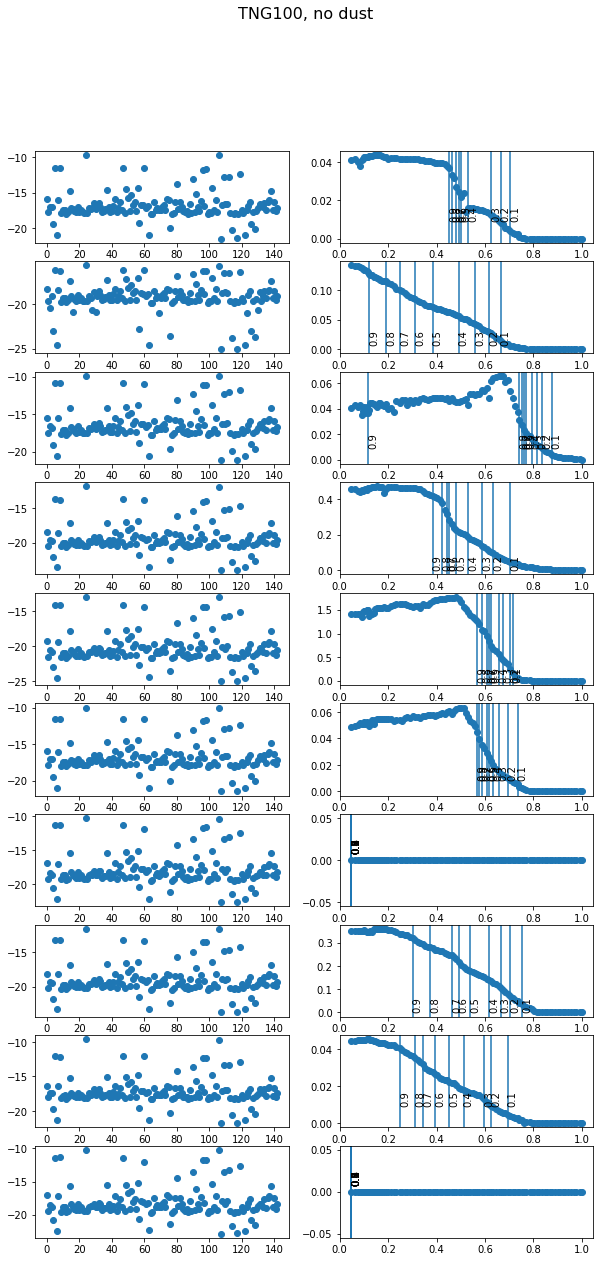

In [ ]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(10, 2)
fig.set_size_inches(10, 20)
fig.suptitle("TNG100, no dust", fontsize=16)
i = 0
for (batch, entry) in enumerate(train_dset.take(10)):
  # print(entry['quantile'])
  # cutouts.append(entry['image'])    sh = 
  # obj=phot_cat.loc[sh][:]
    #apparent mags
  # app_mag = obj.values+5*(np.log10(20e6)-1) #assume at 20pc
  flux = entry['flux']
  mass = entry['mass']
  # print(flux.shape, entry['time'])
  axs[i, 0].scatter(np.arange(len(flux)), flux)
  axs[i, 1].scatter(entry['time'], mass)
  for j in range(9):
    quantile = entry['quantile'][j]
    axs[i, 1].axvline(quantile)
    axs[i, 1].text(quantile, 0.01, (j+1)/10, rotation='vertical')
  i += 1
    